# <center> Практические задания по цифровой обработке сигналов </center>
# <center> Вторая лабораторная работа </center>
# <center> Анализ сигналов </center>

In [1]:
import librosa
import numpy as np
import scipy 
import scipy.fft
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display
import librosa.filters
import hashlib

# Запретим numpy выполнять деление на 0
np.seterr(divide='raise', invalid='raise') 
%matplotlib inline

In [2]:
# Определим две функции для отрисовки сигнала. 
def draw_waveform(wav, sr, figsize=(14, 5)):
    # Отрисовка звукового сигнала во временной области
    plt.figure(figsize=figsize)
    librosa.display.waveplot(wav, sr=sr)

def draw_sig(frames, name=None, figsize=(14, 3)):
    # Отрисовка сигнала в виде "леденцов на палочке"
    plt.figure(figsize=figsize)
    plt.stem(frames)
    if name is not None:
        plt.legend([name])
    plt.xlabel("n")
    plt.ylabel("Energy")
    plt.show()
    

In [3]:
# Создадим несколько простых сигналов. Они нам понадобятся для дальшейшего тестирования
signals = {}

<ipython-input-2-d984687c02b2>:10: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(frames)


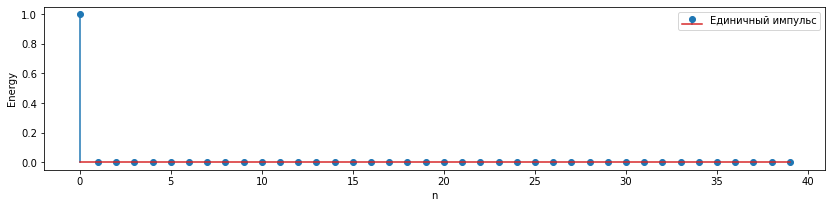

In [4]:
name = "Единичный импульс"
signals[name] = np.array([1] + [0]*39, dtype=float)
draw_sig(signals[name], name)

<ipython-input-2-d984687c02b2>:10: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(frames)


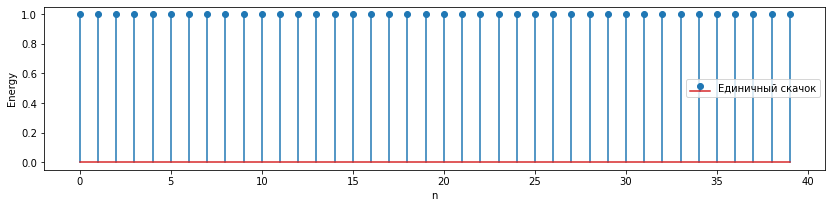

In [5]:
name = "Единичный скачок"
signals[name] = np.array([1]*40 ,dtype=float) 
draw_sig(signals[name], name)

<ipython-input-2-d984687c02b2>:10: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(frames)


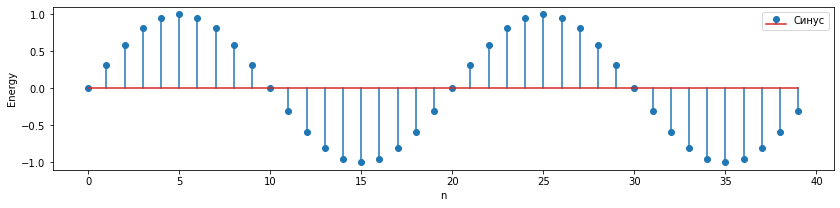

In [6]:
name = "Синус"
signals[name] = np.sin(np.pi * np.arange(40)/10)
draw_sig(signals[name], name)

<ipython-input-2-d984687c02b2>:10: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(frames)


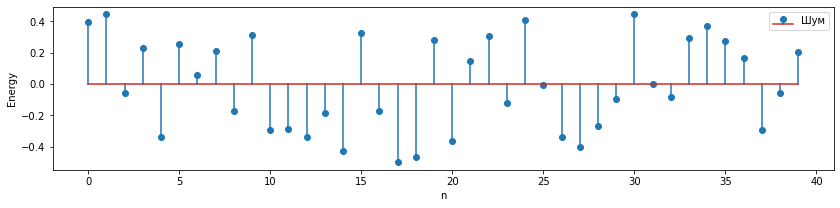

In [7]:
name = "Шум"
signals[name] = np.random.random(40)-0.5
draw_sig(signals[name], name)

-------------------------------
# Преобразование Фурье
Прежде, чем перейти к анализу сигналов, надо разобраться, что такое преобразование Фурье. 
> Преобразование Фурье (символ ℱ) — операция, сопоставляющая одной функции вещественной переменной другую функцию вещественной переменной. Эта новая функция описывает коэффициенты («амплитуды») при разложении исходной функции на элементарные составляющие — гармонические колебания с разными частотами (подобно тому, как музыкальный аккорд может быть выражен в виде суммы музыкальных звуков, которые его составляют). [Wiki](https://ru.wikipedia.org/wiki/%D0%9F%D1%80%D0%B5%D0%BE%D0%B1%D1%80%D0%B0%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%A4%D1%83%D1%80%D1%8C%D0%B5)



Формула прямого дискретного преобразования Фурье (ДПФ, Discrete Fourier Transform, DFT)):
$$ X_k = \sum_{n=0}^{N-1} x_n * e^{2i\pi k n/N} $$


# Задание 1 (2 балла)
Реализовать дискретное преобразование Фурье. Сравнить с реализацией scipy.fft.fft

In [8]:
def DFT(x):
    # YOUR CODE HERE
#     raise NotImplementedError()
    N = len(x)
    ans_list = []
    for k in range(N):
        ans_list.append(x.T.dot(np.exp((-2j*np.pi*k/N) * np.arange(N))))
        
    return np.array(ans_list)

In [9]:
def test_DTF(x, transform=DFT):
    # Сравнение с библиотекой scipy
    scipy_result = scipy.fft.fft(x)
    curr_result = transform(x)
    if scipy_result.shape != curr_result.shape:
        print("TEST_FAILED")
        print(f"Your spectrogram shape is {curr_result.shape}. "
              f"Scipy spectrogram shape is {scipy_result.shape}")
        return -1
    if not np.allclose(curr_result, scipy_result):
        print("TEST FAILED")
        print(f"scipy spectrogram: {scipy_result}")
        print(f"Your DTF spectrogram: {curr_result}")
        print(f"Average diff is {np.mean(np.abs(scipy_result - curr_result))}")
        return -2
    print("TEST PASSED")
    return 0

for name, sig in signals.items():
    print(f"Checking '{name}'")
    assert test_DTF(sig) == 0, "Check you implementation"
print("All ok!")

Checking 'Единичный импульс'
TEST PASSED
Checking 'Единичный скачок'
TEST PASSED
Checking 'Синус'
TEST PASSED
Checking 'Шум'
TEST PASSED
All ok!


Класическое ДПФ имеет существенный недостаток - сложность алгоритма $O(N^2)$. На данный момент существуют чуть более сложные реализации преобразования Фурье, которые избавляются от квадратичной сложности. Например, алгоритм быстрого преобразования Фурье (Fast Fourier Transform, FFT) имеет сложность $O(N log(N))$, что делает его значительно более быстрым на длинных последовательностях. 

# Задание 1.1* (1 балл)
Реализовать быстрое преобразование Фурье. Сравнить с scipy.fft.fft

In [10]:
# def FFT(x):
#     # YOUR CODE HERE
#     raise NotImplementedError()

def FFT(x):
    """A recursive implementation of the 1D Cooley-Tukey FFT"""
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    
    if N % 2 > 0:
        raise ValueError("size of x must be a power of 2")
    elif N <= 32:  # this cutoff should be optimized
        return DFT(x)
    else:
        X_even = FFT(x[::2])
        X_odd = FFT(x[1::2])
        factor = np.exp(-2j * np.pi * np.arange(N) / N)
        return np.concatenate([X_even + factor[:N // 2] * X_odd,
                               X_even + factor[N // 2:] * X_odd])

In [11]:
for name, sig in signals.items():
    print(f"Checking '{name}'")
    assert test_DTF(sig, transform=FFT) == 0, "Check you implementation"
print("All ok!")

Checking 'Единичный импульс'
TEST PASSED
Checking 'Единичный скачок'
TEST PASSED
Checking 'Синус'
TEST PASSED
Checking 'Шум'
TEST PASSED
All ok!


# Амплитудный и фазовый спектры
Поскольку преобразование Фурье определено в комплекстной области, анализировать результат напрямую проблематично. Для анализа сигналов принято разбивать результат преобразования Фурье на два спектра: амплитудный и фазовый. Амплитудный показывает, как меняется модуль сигнала, а фазовый - как меняется угол, образуемый на комплексной плоскости. 
# Задание 2 (1 балл)

Реализовать функции построения амплитудного и фазового спектра

In [12]:
#функция построения амплитудного спектра
def get_magnitude_from_spec(spec):
#     # YOUR CODE HERE
#     raise NotImplementedError()
    return np.abs(spec)

#функция построения фазового спектра
def get_phi_from_spec(spec):
#     YOUR CODE HERE
#     raise NotImplementedError()
    
    return np.arctan([spec.imag[i]/spec.real[i] if spec.real[i]!=0 else np.inf for i in range(len(spec))])

In [13]:
def check_mean_var(sig, mean=None, var=None):
    if mean is not None and np.mean(sig) != mean:
        print(f"Bad mean. Expected {mean}, got {np.mean(sig)}")
        return False
    if var is not None and np.var(sig) != var:
        print(f"Bad var. Expected {var}, got {np.var(sig)}")
        return False
    return True

_spec = scipy.fft.fft(np.array([1]+[0]*10))
assert check_mean_var(get_magnitude_from_spec(_spec), 1.0, 0.0), \
    "Wrong magnitude"
assert check_mean_var(get_phi_from_spec(_spec), 0.0, 0.0), \
    "Wrong phase"

    
_spec = scipy.fft.fft(np.array([1]*10))
assert check_mean_var(get_magnitude_from_spec(_spec), 1.0, 9.0), \
    "Wrong  magnitude"
assert get_magnitude_from_spec(_spec)[0] == 10, \
    "Wrong magnitude"
assert get_phi_from_spec(_spec)[0] == 0, \
    "Wrong phase"

_spec = scipy.fft.fft(scipy.fft.ifft(np.array([0] + [10+5j]+[0]*6 + [10-5j])))
assert get_magnitude_from_spec(_spec).round(1)[1] == 11.2 , \
    "Wrong magnitude. Make sure it is a complex number module."
assert get_phi_from_spec(_spec).round(1)[1] == 0.5 , \
    "Wrong phase. Make sure it is an angle."

   
print("All OK!")

All OK!


In [14]:
# Определим еще одну функцию для отрисовки
# Теперь будем рисовать сигнал в частотной области
def draw_spec(spec, name=None, draw_A=True, draw_p=True, figsize=(14, 3)):
    if len(spec)<100:
        # Рисуем точки как "леденцы на палочках"
        draw_func = plt.stem
    else:
        # При большом N "леденцы" выглядят плохо, 
        # Поэтому будем рисовать огибающую функцию
        draw_func = plt.plot
    
    if draw_A:
        plt.figure(figsize=figsize)
        plt.title("Magnitude spectrum")
        spec_A = get_magnitude_from_spec(spec)
        draw_func(spec_A)
        plt.ylabel("Magnitude")
        plt.xlabel("n")
        if name is not None:
            plt.legend([name])
        plt.show()
        
    if draw_p:
        plt.figure(figsize=figsize)
        plt.title("Phase spectrum")
        phi = get_phi_from_spec(spec)
        draw_func(phi)
        plt.ylabel("Radian")
        plt.xlabel("n")
        if name is not None:
            plt.legend([name])
        plt.show()
    return 

# Задание 2.1 (0.5 балла)
Постройте спектры для всех сигналов из коллекции signals и ответьте на вопросы:
1. Почему амплитуда всех гармоник единичного импульса равна единице? 
1. Какие выводы можно сделать смотря на амплитудный спектр? А на фазовый? 
1. Как перевести номер отсчета в частоту?  
1. Что в фазовом спектре является полезной информацией, а что - шумом? Почему?

1. - Мы применяем преобразование Фурье ко всему сигналу. Амплитуда не равна 0 только в самый первый момент времени, поэтому вклад в сумму в преобразовании Фурье будет вносить только эта амплитуда для всех частот, потому что номер частоты используется только в степени у экспоненты в преобразовании Фурье.
2. - Смотря на амплитудный спектр можно понять какие главные частоты у сигнала.
3. - Надо номер отсчета умножить на частоту дискретизации и разделить на длину сигнала.
4. - В фазовом спектре вся информация полезна и менять фазовый спектр не рекомендуется, поскольку именно фазовый спектр несет основную информацию о сигнале.

Drawing 'Единичный импульс'


<ipython-input-14-971fc261ab71>:16: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  draw_func(spec_A)


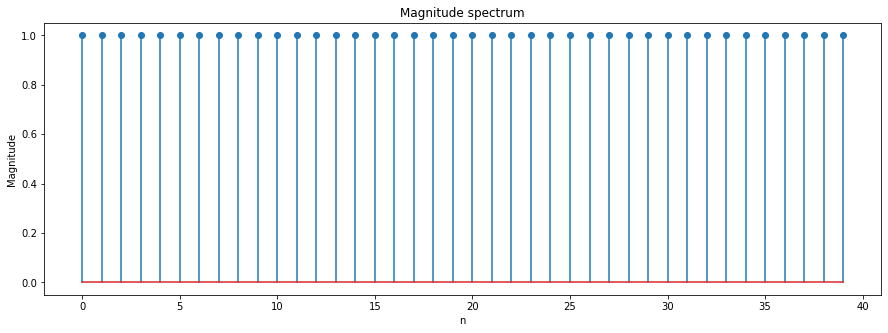

<ipython-input-14-971fc261ab71>:27: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  draw_func(phi)


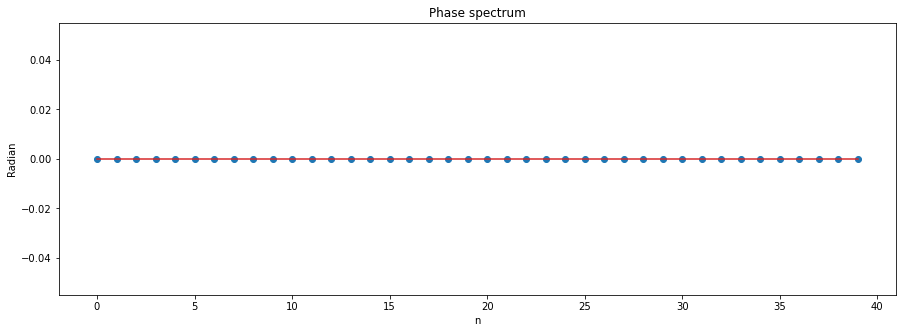

Drawing 'Единичный скачок'


<ipython-input-14-971fc261ab71>:16: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  draw_func(spec_A)


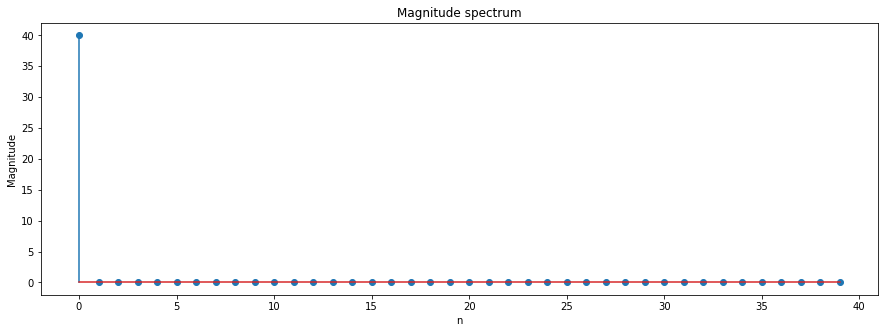

<ipython-input-14-971fc261ab71>:27: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  draw_func(phi)


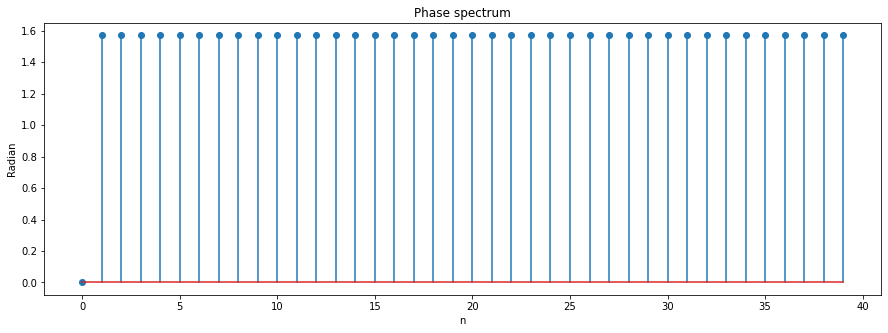

Drawing 'Синус'


<ipython-input-14-971fc261ab71>:16: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  draw_func(spec_A)


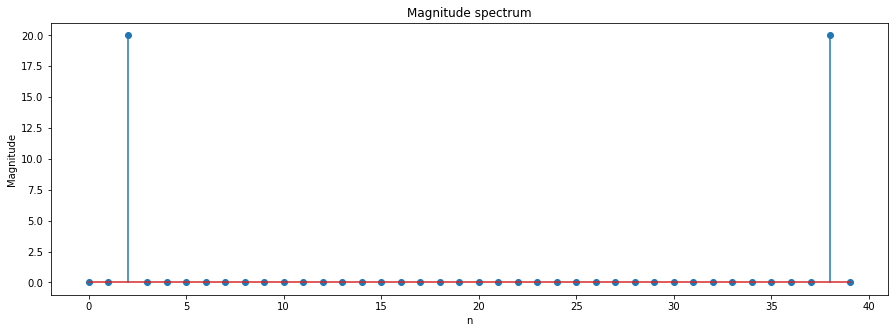

<ipython-input-14-971fc261ab71>:27: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  draw_func(phi)


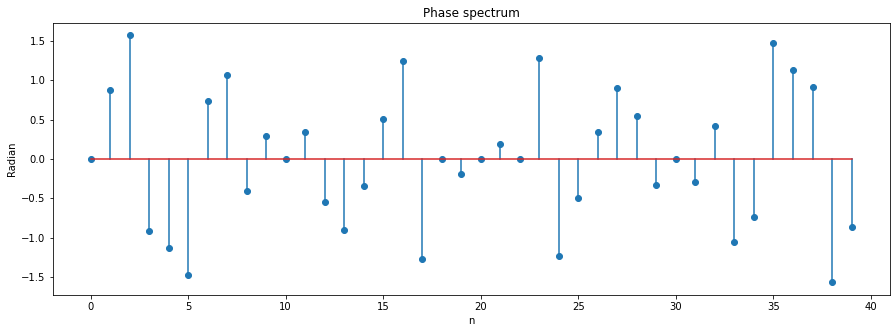

Drawing 'Шум'


<ipython-input-14-971fc261ab71>:16: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  draw_func(spec_A)


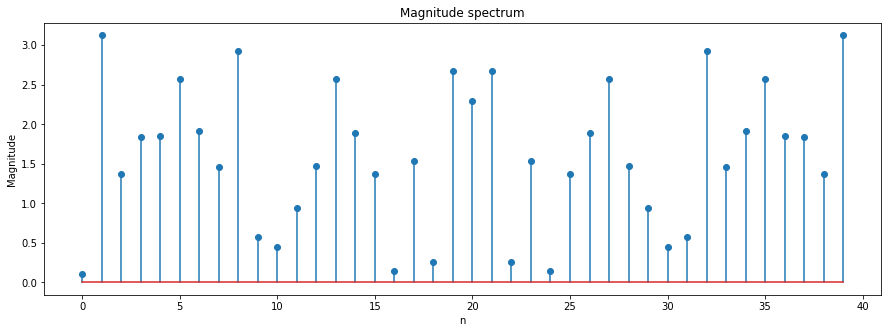

<ipython-input-14-971fc261ab71>:27: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  draw_func(phi)


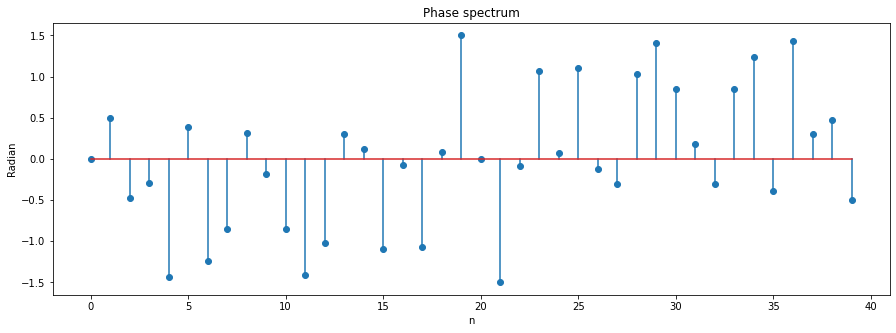

In [15]:
for name, sig in signals.items():
    print(f"Drawing '{name}'")
    sig_spec = scipy.fft.fft(sig)
    draw_spec(sig_spec, draw_p=True, figsize=(15,5))

# Оконное преобразование Фурье
Преобразование Фурье делает переход из временной области в частотную, позволяя анализировать составляющие сигнал гармоники. Однако это не всегда удобно. В реальных сигналах зачастую составляющие их гармоники изменяются со временем. Например, каждая буква в слове имеет свой набор основных гармоник, и простое преобразование Фурье не сильно поможет нам определить, что было сказано. Для того, чтобы анализировать такие сигналы, обычно используется [Оконное преобразование Фурье](https://ru.wikipedia.org/wiki/Оконное_преобразование_Фурье). Такое преобразование позволяет анализировать гармоники сигнала в коротких промежутках времени и сохранить временную ось при построении спектрограммы.
# Задание 3 (2 балла)
Реализовать оконное преобразование Фурье, пользуясь только библиотеками numpy и scipy. Сравнить с librosa.stft


In [16]:
def STFT(x, n_fft=2048, hop_length=512, window='hann'):
    #  Short-time Fourier transform
    # x - signal
    # n_fft - fft window size 
    # hop_length - step size between ffts
    # window - window type. See scipy.signal.get_window
    # return spectrogram 
    
#     # YOUR CODE HERE
#     raise NotImplementedError()
    N = len(x)
    spec_freq = []
    for k in range((n_fft+2)//2):
        spec_time = []
        for m in np.linspace(0, N, (N // hop_length) + 1):
            left = int(m-n_fft/2)
            right = int(m+n_fft/2)
            if left < 0:
                in1 = np.append(x[1 : -left+1][::-1], x[0 : right])
            elif right > N:
                in1 = np.append(x[left : ], x[(N-right)-1 : -1][::-1])
            else:
                in1 = x[left : right]
            in2 = scipy.signal.get_window(window, n_fft)
            in3 = np.exp((-2j*np.pi/n_fft)*k*np.arange(n_fft))
            
            spec_time.append(np.sum(in1*in2*in3))
        spec_freq.append(spec_time)

    return np.array(spec_freq)
    
    
    

In [17]:
def test_stft(x, n_fft=2048, hop_length=512, window='hann'):
    librosa_result = librosa.stft(x, n_fft=n_fft, hop_length=hop_length, window='hann', center=True)
    result = STFT(x, n_fft=n_fft, hop_length=hop_length, window='hann')
    if librosa_result.shape != result.shape:
        print(f"Your shape {result.shape} != librosa stft shape {librosa_result.shape} ")
        return -1 
    if not np.allclose(librosa_result, result):
        print(f"Wrong results. Diff {np.abs(librosa_result-result)}")
        return -2
    return 0
        
for name, sig in signals.items():
    print(f"Checking '{name}'")
    for n_fft in (8, 4):
        for hop_length in (n_fft//4, n_fft//2):
            assert test_stft(sig, n_fft=n_fft, hop_length=hop_length)==0, \
                f"Test failed. Params n_fft {n_fft}. Hop_length {hop_length}"
    print("ok")
print("All ok!")

Checking 'Единичный импульс'
ok
Checking 'Единичный скачок'
ok
Checking 'Синус'
ok
Checking 'Шум'
ok
All ok!


In [18]:
# Определим функцию для отрисовки
def draw_stft(X, sr, figsize=(14, 5)):
    plt.figure(figsize=figsize)
    # X - комплекстная спектрограмма 
    # Для получения энергии достаточно взять модуль
    Xdb = librosa.amplitude_to_db(abs(X))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.show()

# Анализ сигналов
Теперь можно приступить к анализу звуковых сигналов.
Во время анализа сигналов нам понадобятся все определенные выше инструменты. 


----------------------------------
## Анализ паровозного гудка
Начнем с простого сигнала, состоящего из нескольких основных гармоник и шума.

Len is 82175 ( ). Sample rate is 22050


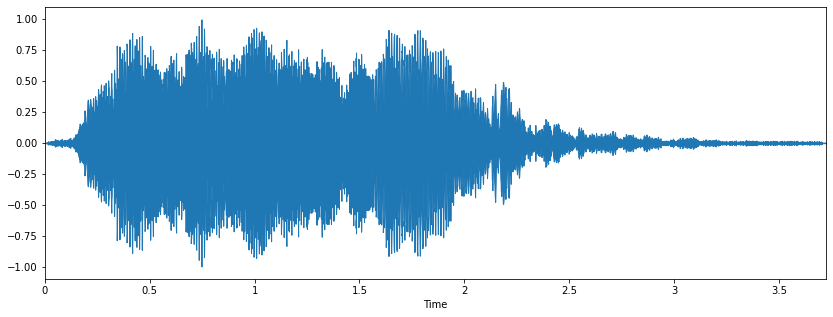

In [19]:
# Загрузим аудио файл с паровозным гудком
train_whistle, tw_sr = librosa.core.load("resources/train_whistle.wav")
print(f"Len is {len(train_whistle)} ( ). Sample rate is {tw_sr}")
player = ipd.Audio(train_whistle, rate=tw_sr)
ipd.display(player)
draw_waveform(train_whistle, sr=tw_sr)

Гудок паровоза в частотной области


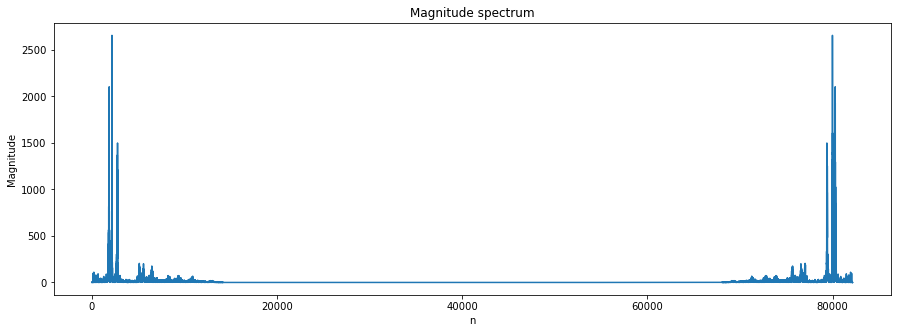

In [20]:
train_whistle_spec = scipy.fft.fft(train_whistle)
print("Гудок паровоза в частотной области")
draw_spec(train_whistle_spec, draw_p=False, figsize=(15,5))

# Задание 4 (2 балла)
Определите 3 основные гармоники паровозного гудка.

Ответ округлите до двух знаков после запятой.


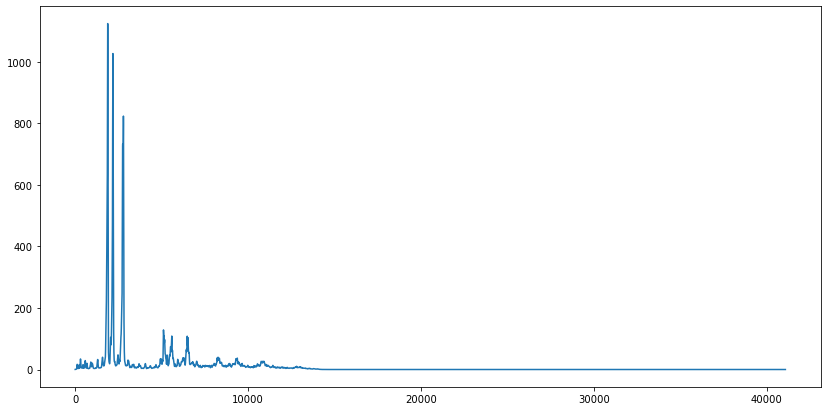

[504.45999392 584.95892911 748.37176757]


In [21]:
# YOUR CODE HERE
# task_answer = [ freq1, freq2, freq3 ] 

amplitude = abs(train_whistle_spec)[:len(train_whistle_spec) // 2]

plt.figure(figsize=(14, 7))
x = np.arange(0, len(train_whistle_spec) // 2, 1)
y = amplitude

w=np.hanning(50)
y_new=np.convolve(w/w.sum(),y,mode='same')
plt.plot(x,y_new)
plt.show()

peaks, _ = scipy.signal.find_peaks(y_new, distance=10)
nums = peaks[y_new[peaks].argsort()[-3:][::-1]]
task_answer = nums * 22050 / len(train_whistle_spec)
print(task_answer)

In [22]:
assert type(task_answer) == list or type(task_answer) == np.ndarray, \
        f"Wrong answer type. Expected list or numpy array. Got {type(task_answer)}"
assert len(task_answer) == 3, \
        f"Wrong len {len(task_answer)}."
assert (round(sum(task_answer)) == 1677 and round(np.var(task_answer)) == 1407) or \
        (abs(sum(task_answer)  - 1836) <= 3 and abs(np.var(task_answer) - 10153) <= 181), \
        f"Wrong freqs"
print("Correct!")      

Correct!


Теперь попробуйте сгенерировать сигнал, состоящий только из этих гармоник. Воспроизведите сигнал.

In [23]:
#YOUR CODE HERE
N = len(train_whistle_spec)
train_whistle_spec_new = train_whistle_spec[nums[:3]]
A = abs(train_whistle_spec_new)/N
phi = np.arctan([train_whistle_spec_new.imag[i]/train_whistle_spec_new.real[i] if train_whistle_spec_new.real[i]!=0 else np.inf for i in range(len(train_whistle_spec_new))])

In [24]:
k = 0
x = A[k] * np.exp(1j * ((2 * np.pi / N) * nums[k] * np.arange(N) + phi[k]))
for k in range(1, 3):
    x += A[k] * np.exp(1j * ((2 * np.pi / N) * nums[k] * np.arange(N) + phi[k]))

C:\Users\artys\anaconda3\lib\site-packages\IPython\lib\display.py:157: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)


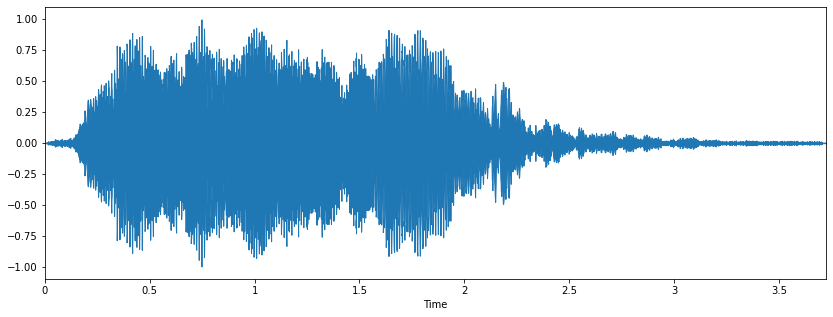

In [25]:
player = ipd.Audio(x, rate=22050)
ipd.display(player)
draw_waveform(train_whistle, sr=22050)

# Анализ двухтонального многочастотного сигнала
Теперь расмотрим более сложный сигнал - [DTMF](https://en.wikipedia.org/wiki/Dual-tone_multi-frequency_signaling). Такие сигналы используются для автоматизации набора телефонного номера. 

# Задание 5 (2 балла)
В данном аудио закодирован трехзначный номер. Используя таблицу с [wiki]:(https://ru.wikipedia.org/wiki/DTMF) определите, что за номер закодирован.


Len is 243102. Sample rate is 22050


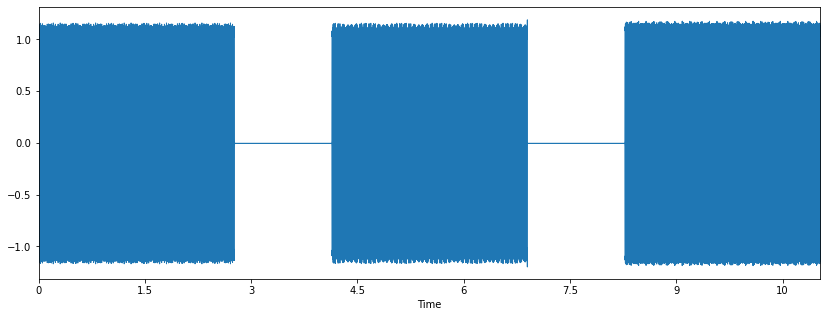

In [26]:
#dtmf.wav
dtmf, dtmf_sr = librosa.core.load("resources/dtmf.wav")
print(f"Len is {len(dtmf)}. Sample rate is {dtmf_sr}")
player = ipd.Audio(dtmf, rate=dtmf_sr)
ipd.display(player)
draw_waveform(dtmf, sr=dtmf_sr)

In [27]:
# YOUR CODE HERE
# phone_number = [first: int, second: int, third: int]

X = librosa.stft(dtmf, n_fft=int(dtmf.shape[0]/3), hop_length=int(dtmf.shape[0]/3), window='hann', center=False)
Xdb = abs(X)

print(f'Кнопка №1 : {Xdb[:, 0].argsort()[::-1][:2] * 3*dtmf_sr/len(dtmf)}')

print(f'Кнопка №2 : {Xdb[:, 1].argsort()[::-1][:2] * 3*dtmf_sr/len(dtmf)}')

print(f'Кнопка №3 : {Xdb[:, 2].argsort()[::-1][:2] * 3*dtmf_sr/len(dtmf)}')

phone_number = [1, 5, 9]
print(f'Кнопки: {phone_number}')

Кнопка №1 : [1208.97586198  696.86859837]
Кнопка №2 : [1336.05029987  770.06565145]
Кнопка №3 : [1477.00224597  851.97016067]
Кнопки: [1, 5, 9]


In [28]:
assert type(phone_number) == list or type(phone_number) == np.ndarray, \
        f"Wrong answer type. Expected list or numpy array. Got {type(phone_number)}"
assert len(phone_number) == 3, \
        f"Wrong len {len(phone_number)}."
assert round(np.mean(phone_number)) == 5 and round(np.var(phone_number)) == 11 , \
        f"Wrong number"
assert hashlib.md5(''.join(map(str, phone_number)).encode()).hexdigest() == "140f6969d5213fd0ece03148e62e461e", \
        f"Wrong hash. How did you pass mean/var test?"
print("Correct!")   

Correct!
